Covid 19 CT scan Image classification with VGG19 pretrained model.

Datasets: 2 public datasets stored in the folders CT_DATA (CT_COVID and CT_NonCovid) and SARS-COV-2-DATA.

DATA-Split folder : initially used to split data from CT-DATA, but will not be used here in the final.


In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
cov_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_COVID/"
norm_path = "/content/drive/MyDrive/Colab Notebooks/CTCov/CT_Data/CT_NonCOVID/"

In [4]:
IMAGE_SIZE=[224,224]
epochs = 300
batch_size=32
#define paths
covid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/COVID'
noncovid_path = '/content/drive/MyDrive/Colab Notebooks/CTCov/SARS-COV-2-Data/NON-COVID'

# Use glob to grab images from path .jpg or jpeg
cov_files = glob(cov_path + '/*')
norm_files = glob(norm_path + '/*')

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [6]:
# Fetch Images and Class Labels from Files
cov_labels = []
norm_labels = []

cov_images=[]
norm_images=[]

for i in range(len(cov_files)):
  image = cv2.imread(cov_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  cov_images.append(image) # append image
  cov_labels.append('CT_COVID') #append class label
  
for i in range(len(norm_files)):
  image = cv2.imread(norm_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  norm_images.append(image)
  norm_labels.append('CT_NonCOVID')

In [8]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
  
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

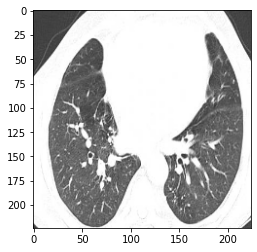

In [9]:
plt.imshow(covid_images[10])

In [10]:
covid_labels[10]

'CT_COVID'

In [11]:
cov_img_all = np.concatenate((covid_images, cov_images), axis=0)
norm_img_all = np.concatenate((noncovid_images, norm_images),axis=0)

In [12]:
covid_labels = np.concatenate((covid_labels, cov_labels), axis=0)
noncovid_labels = np.concatenate((noncovid_labels, norm_labels),axis=0)

In [13]:
len(cov_img_all)

1598

In [14]:
covid_images = np.array(cov_img_all)/255
noncovid_images = np.array(norm_img_all)/255

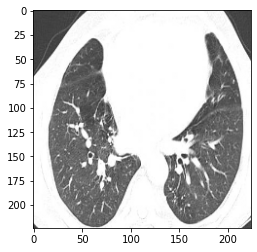

In [15]:
plt.imshow(covid_images[10])

In [16]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)


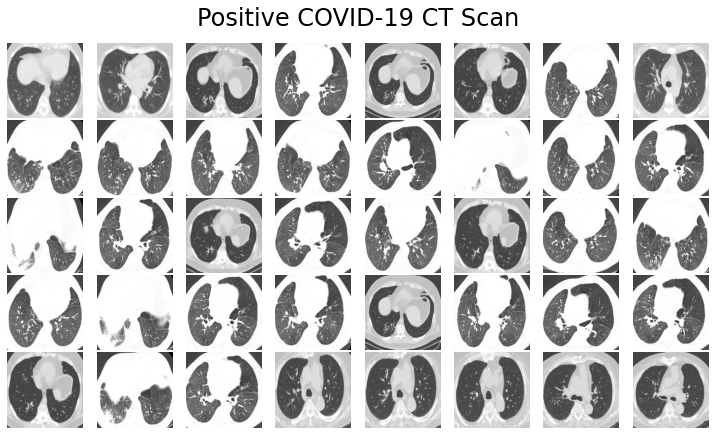

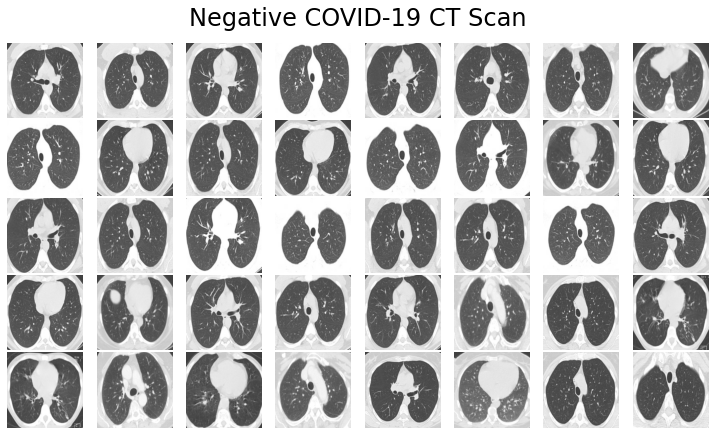

In [17]:
# look at some images
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

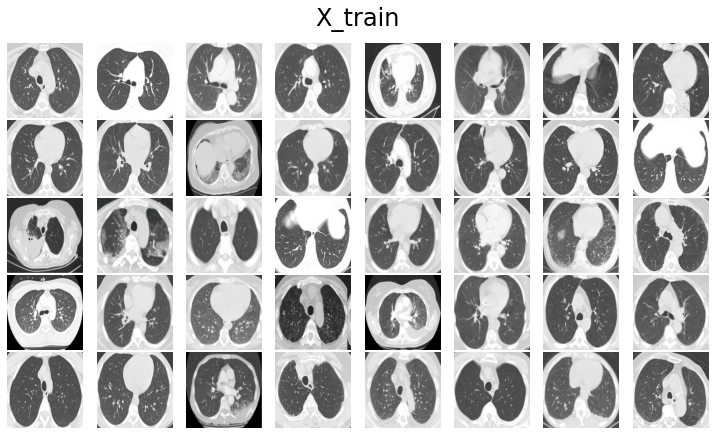

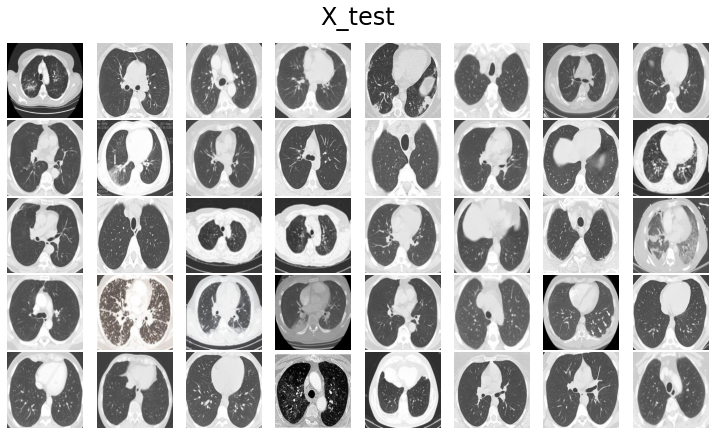

In [18]:
plot_images(X_train, 'X_train')
plot_images(X_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

# ResNet50 model

In [19]:

# Building Model
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94781440/94765736 [==============================] - 1s 0us/step


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
res = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/300
80/80 [==============================] - 36s 325ms/step - loss: 2.3633 - accuracy: 0.5101 - val_loss: 0.7884 - val_accuracy: 0.5573
Epoch 2/300
80/80 [==============================] - 25s 310ms/step - loss: 1.1536 - accuracy: 0.5419 - val_loss: 1.0373 - val_accuracy: 0.5124
Epoch 3/300
80/80 [==============================] - 25s 311ms/step - loss: 1.2410 - accuracy: 0.5330 - val_loss: 0.6073 - val_accuracy: 0.6749
Epoch 4/300
80/80 [==============================] - 25s 311ms/step - loss: 1.0881 - accuracy: 0.5675 - val_loss: 0.5702 - val_accuracy: 0.7198
Epoch 5/300
80/80 [==============================] - 25s 310ms/step - loss: 1.0097 - accuracy: 0.5675 - val_loss: 0.6098 - val_accuracy: 0.6904
Epoch 6/300
80/80 [==============================] - 25s 310ms/step - loss: 0.9984 - accuracy: 0.5803 - val_loss: 0.7829 - val_accuracy: 0.5867
Epoch 7/300
80/80 [==============================] - 25s 312ms/step - loss: 1.1961 - accuracy: 0.5811 - val_loss: 0.5983 - val_accuracy:

In [22]:
# Save Model and Weights
model.save('/content/drive/MyDrive/Colab Notebooks/CTCov/Models/res_ct.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/CTCov/Models/res_weights_ct.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [23]:
y_pred = model.predict(X_test, batch_size=batch_size)

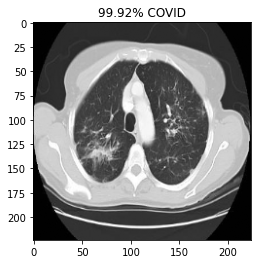

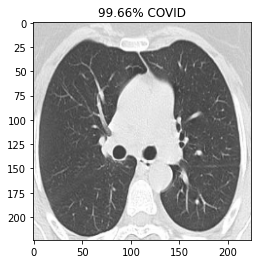

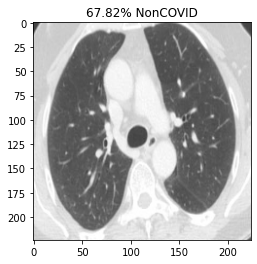

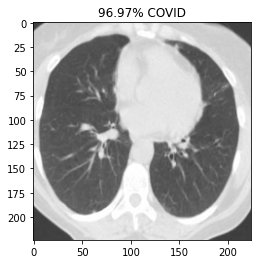

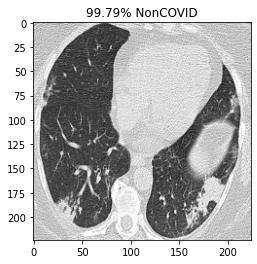

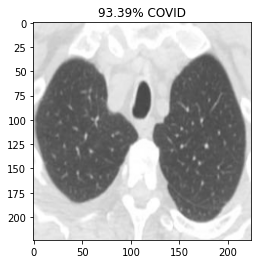

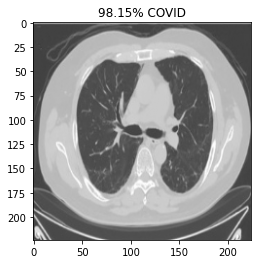

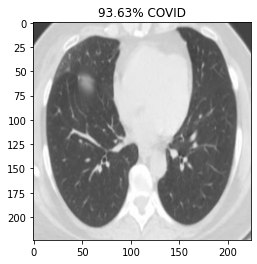

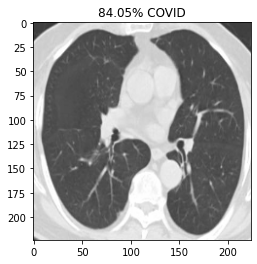

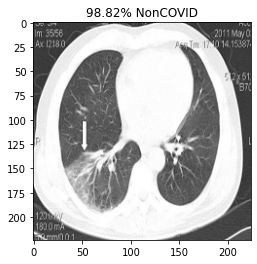

In [24]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [25]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [26]:
from sklearn.metrics import classification_report
report = classification_report(y_test_bin, y_pred_bin, output_dict=True)
print(report)

{'0': {'precision': 0.7813504823151125, 'recall': 0.759375, 'f1-score': 0.7702060221870048, 'support': 320}, '1': {'precision': 0.7701492537313432, 'recall': 0.7914110429447853, 'f1-score': 0.7806354009077155, 'support': 326}, 'accuracy': 0.7755417956656346, 'macro avg': {'precision': 0.7757498680232279, 'recall': 0.7753930214723926, 'f1-score': 0.7754207115473601, 'support': 646}, 'weighted avg': {'precision': 0.7756978499338296, 'recall': 0.7755417956656346, 'f1-score': 0.77546914519467, 'support': 646}}


In [27]:
import pandas as pd
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.781350,0.759375,0.770206,320.000000
1,0.770149,0.791411,0.780635,326.000000
accuracy,0.775542,0.775542,0.775542,0.775542
macro avg,0.775750,0.775393,0.775421,646.000000
weighted avg,0.775698,0.775542,0.775469,646.000000


In [28]:
# or save to csv: 
report_csv_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_class_report.csv'
with open(report_csv_file, mode='w') as f:
    report_df.to_csv(f)

In [29]:
test_report = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_class_report.csv')
test_report

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.781350,0.759375,0.770206,320.000000
1,1,0.770149,0.791411,0.780635,326.000000
2,accuracy,0.775542,0.775542,0.775542,0.775542
3,macro avg,0.775750,0.775393,0.775421,646.000000
4,weighted avg,0.775698,0.775542,0.775469,646.000000


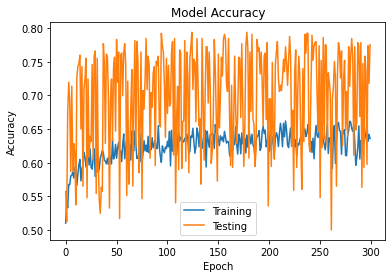

In [30]:
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_ct_accuracy.png')
plt.show()

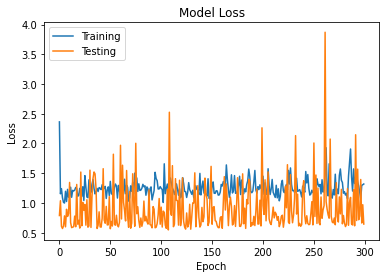

In [31]:
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_ct_loss.png')
plt.show()

Confusion Matrix without Normalization


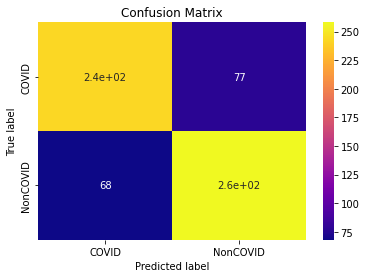

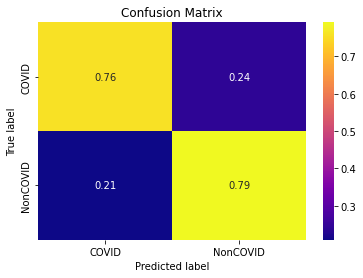

In [32]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  if normalize != 'true':
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_conf_matrix_not_norm.png")
  else:
    plt.savefig("/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_conf_matrix_norm.png")
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
# print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [33]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(res.history) 

In [34]:
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.363261,0.510085,0.788445,0.557276
1,1.153589,0.541893,1.037318,0.512384
2,1.240986,0.532971,0.607325,0.674923
3,1.088098,0.567494,0.570165,0.719814
4,1.009750,0.567494,0.609805,0.690402


In [35]:
# save to json:  
hist_json_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [36]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CTCov/ResNet50_metrics/res_history.csv')
test_df.head()

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.363261,0.510085,0.788445,0.557276
1,1,1.153589,0.541893,1.037318,0.512384
2,2,1.240986,0.532971,0.607325,0.674923
3,3,1.088098,0.567494,0.570165,0.719814
4,4,1.009750,0.567494,0.609805,0.690402
